## Lets predict the mobility of countries in times of COVID-19.
In recent years, mobility of each country has seen drastic changes due to COVID-19. Let us predict the factors that affect mobility the most. Every country have different variables (e.g. population density, vaccination rate). How can we group country that are similar together? By doing so, can we improve the prediction accuracy?

In [528]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as plt
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

### Cleaning and merging data
- Load CSV
- Drop irrelavant data (e.g. 'World' in continent, and 'tests_units' string column)
- Drop empty rows
- Merge COVID-19 data with mobility data

In [529]:
# Load data
general_data = pd.read_csv("owid-covid-data.csv")
mobility_data = pd.read_csv("changes-visitors-covid.csv")
print(general_data.shape, mobility_data.shape)

# Clean null columns in 'continent
# Data have non-country values under location (e.g. World, Asia)
# Remove 'tests_units' string column
general_data = general_data.dropna(subset=['continent'])
general_data = general_data.drop('tests_units', axis=1)
mobility_data = mobility_data.dropna()
print(general_data.shape, mobility_data.shape)

(169077, 67) (99336, 9)
(158965, 66) (96433, 9)


In [530]:
# general_data_clean = general_data[keep_columns]
# general_data_clean = general_data_clean.dropna()
general_data_clean = general_data
general_data_clean.shape

(158965, 66)

In [531]:
merged_data = pd.merge(general_data_clean, mobility_data, left_on=['iso_code','location','date'], right_on = ['Code','Entity','Day'])
merged_data = merged_data.drop(['Entity', 'Code', 'Day'], axis=1)
merged_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.286,0.286,6.143,2.714,6.000
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.286,0.429,6.143,2.429,6.143
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.571,0.429,6.571,2.571,6.143
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.143,0.571,6.429,2.857,6.286
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.714,5.571,0.857,6.000,2.429,6.143


## Average mobility across different country
- Get list of countries
- Barplot mean mobility for each country

In [532]:
countries = merged_data.drop_duplicates(subset = ["location"])[['location']].values.flatten().tolist()
print(countries)

['Afghanistan', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Chile', 'Colombia', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Haiti', 'Honduras', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Libya', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mali', 'Malta', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North

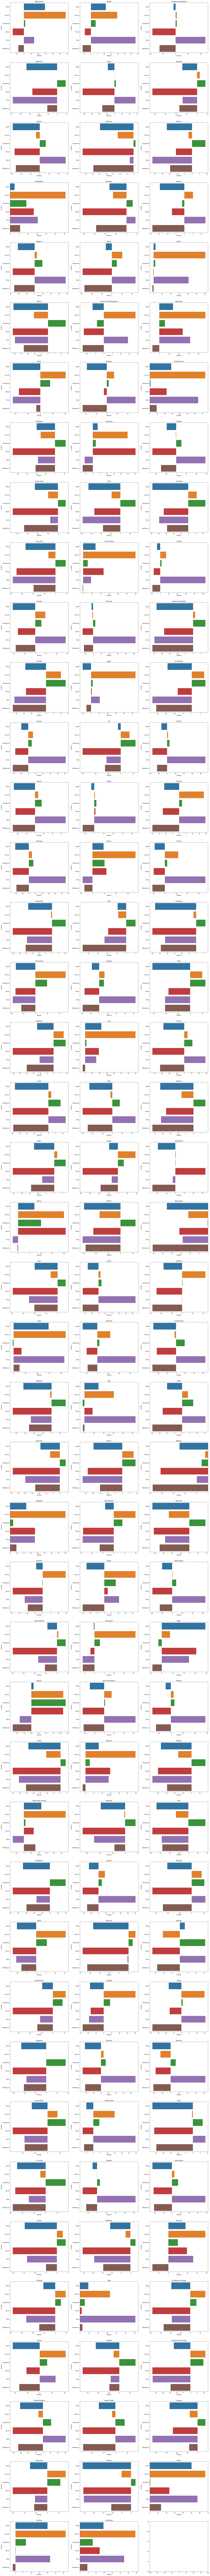

In [533]:
graph_per_row = 3
row = int(len(countries)/graph_per_row)+1
f, axes = plt.subplots(row, graph_per_row, figsize=(30, 400))
plt.xlim(-100, 100)

i = 0
for c in countries:
    country_data = merged_data.loc[merged_data['location'] == c]
    retail = country_data['retail_and_recreation'].mean()
    grocery = country_data['grocery_and_pharmacy'].mean()
    residential = country_data['residential'].mean()
    transit = country_data['transit_stations'].mean()
    parks = country_data['parks'].mean()
    workplaces = country_data['workplaces'].mean()
    mobility_location = pd.DataFrame({'Location':['Retail', 'Grocery', 'Residential', 'Transit', 'Parks', 'Workplaces'], 
                                    'Mobility':[retail, grocery, residential, transit, parks, workplaces]})
    sb.barplot(x='Mobility',y='Location',data=mobility_location, ax = axes[i//graph_per_row,i%graph_per_row], orient='h').set_title(c)
    i+=1

As we can see the average mobility differs across each country. How can we group country that are similar together?

## K-Means Clustering for countries by country's development
- Get latest data for each country
- EDA for PCA & K-Means
- Assign a cluster to every country

In [145]:
# Grab column that is needed for classification
cluster_data = pd.DataFrame(merged_data[["location", "date", "population_density", "gdp_per_capita", "life_expectancy", "human_development_index"]])
cluster_data = cluster_data.dropna()
cluster_data.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index
0,Afghanistan,2020-02-24,54.422,1803.987,64.83,0.511
1,Afghanistan,2020-02-25,54.422,1803.987,64.83,0.511
2,Afghanistan,2020-02-26,54.422,1803.987,64.83,0.511
3,Afghanistan,2020-02-27,54.422,1803.987,64.83,0.511
4,Afghanistan,2020-02-28,54.422,1803.987,64.83,0.511


In [146]:
# Grab the latest data by sorting first then keeping the last data for each location
cluster_data = cluster_data.sort_values(by=['date']).drop_duplicates(subset='location', keep='last')

# Reset index for ease in combination of data later on
cluster_data.reset_index(drop=True, inplace=True)
cluster_data.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index
0,Vietnam,2021-10-23,308.127,6171.884,75.40,0.704
1,Niger,2022-03-12,16.955,926.000,62.42,0.394
2,Nepal,2022-03-12,204.430,2442.804,70.78,0.602
3,Namibia,2022-03-12,3.078,9541.808,63.71,0.646
4,Netherlands,2022-03-12,508.544,48472.545,82.28,0.944


In [147]:
# Drop location & date in prepation for classification
kmean_data = cluster_data.drop(columns=['location' ,'date'])
kmean_data.head()

,population_density,gdp_per_capita,life_expectancy,human_development_index
0,308.127,6171.884,75.40,0.704
1,16.955,926.000,62.42,0.394
2,204.430,2442.804,70.78,0.602
3,3.078,9541.808,63.71,0.646
4,508.544,48472.545,82.28,0.944


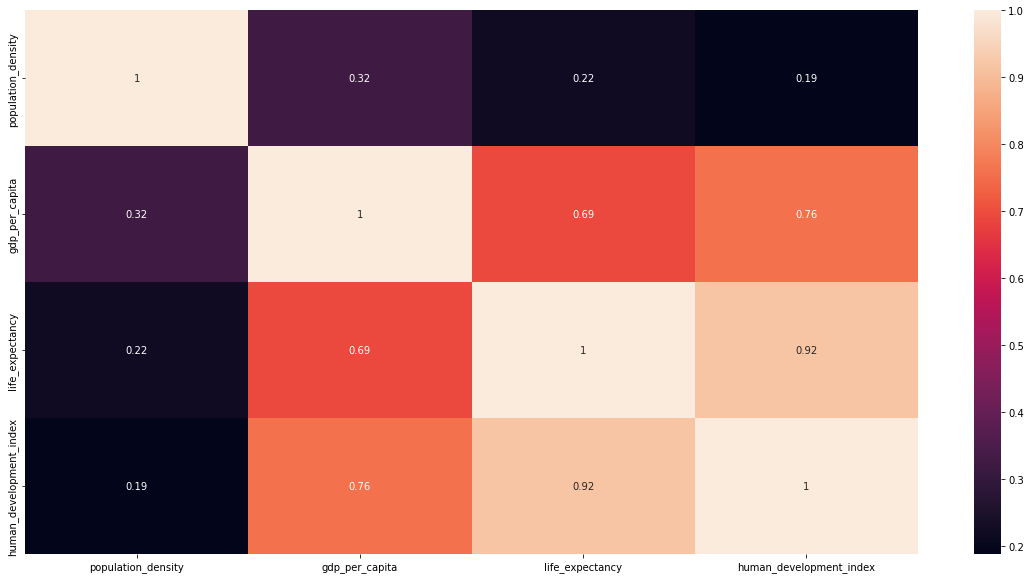

In [148]:
# Analysis for K-Means Clustering
# Plot heatmap to show correlation across data
plt.figure(figsize = (20,10))
sb.heatmap(kmean_data.corr(),annot = True)
plt.show()

In [149]:
# Scale variables to a common value
s_scaler = StandardScaler()
kmean_data_scaled = s_scaler.fit_transform(kmean_data)
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(kmean_data_scaled)
pca.components_

array([[ 0.24164155,  0.53760095,  0.56591608,  0.5764838 ],
       [ 0.95345292,  0.0219156 , -0.19287339, -0.2307533 ],
       [-0.17156409,  0.82837606, -0.4826024 , -0.22683429],
       [-0.05570143,  0.15587824,  0.64002639, -0.7503103 ]])

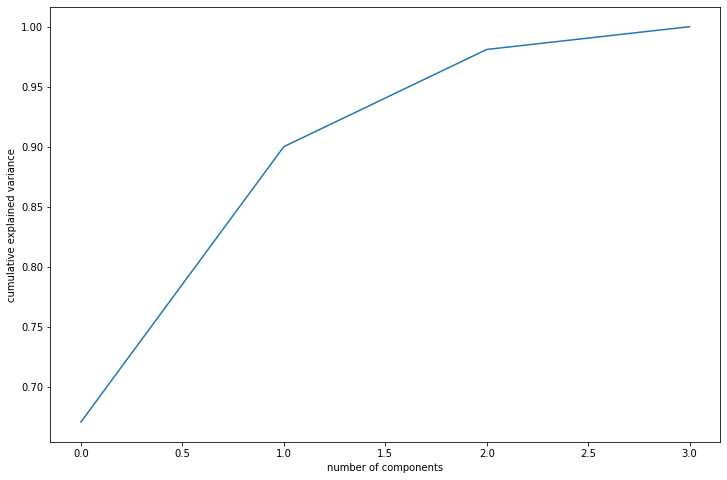

In [150]:
# Plot variance ratio 
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [151]:
# Plot PC values for each variable
colnames = list(kmean_data.columns)
pcs_df = pd.DataFrame({'Feature':colnames,'PC1':pca.components_[0],'PC2':pca.components_[1]})
pcs_df

,Feature,PC1,PC2
0,population_density,0.241642,0.953453
1,gdp_per_capita,0.537601,0.021916
2,life_expectancy,0.565916,-0.192873
3,human_development_index,0.576484,-0.230753


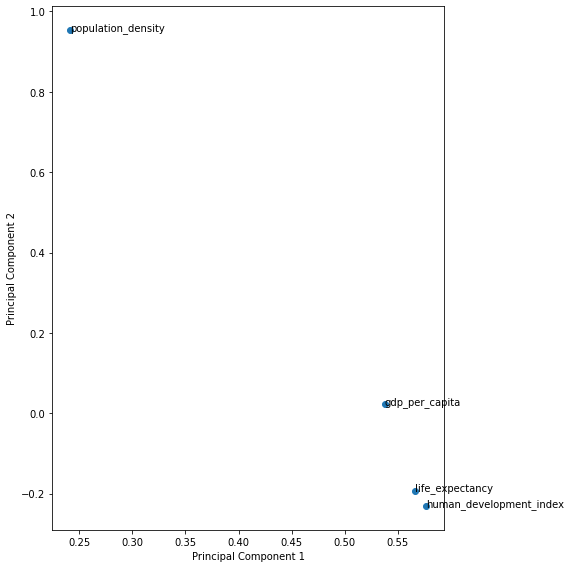

In [152]:
# Plot correlation of PC
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [153]:
# Scale variables according to analysis
pca_final = IncrementalPCA(n_components=2)
df_pca = pca_final.fit_transform(kmean_data_scaled)
df_pca.shape

(126, 2)

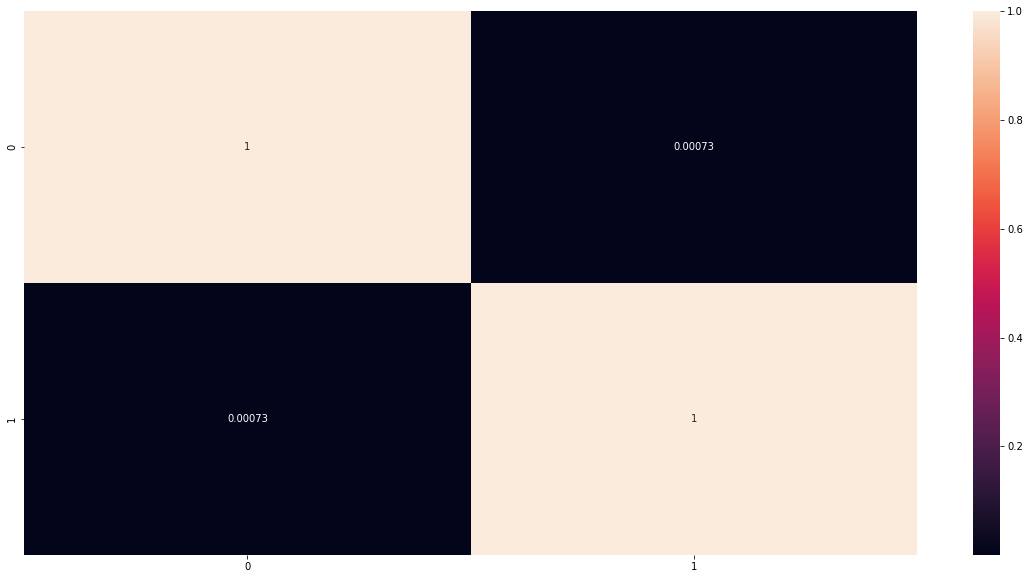

In [154]:
# Plot correlation of PCs
pc = np.transpose(df_pca)
corrmat = np.corrcoef(pc)
plt.figure(figsize=(20,10))
sb.heatmap(corrmat,annot=True)
plt.show()

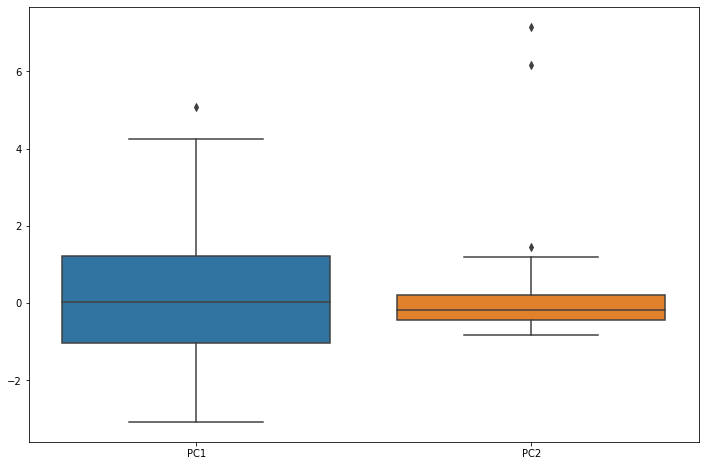

In [155]:
# Boxplot of PCs and outliers
pcs_df2 = pd.DataFrame({'PC1':pc[0],'PC2':pc[1]})
fig = plt.figure(figsize = (12,8))
sb.boxplot(data=pcs_df2)
plt.show()

In [156]:
pcs_df2.shape

(126, 2)

In [157]:
pcs_df2.head()

,PC1,PC2
0,-0.504470,0.041070
1,-3.019560,0.634132
2,-1.414386,0.234534
3,-1.675776,0.184459
4,2.173764,-0.271062


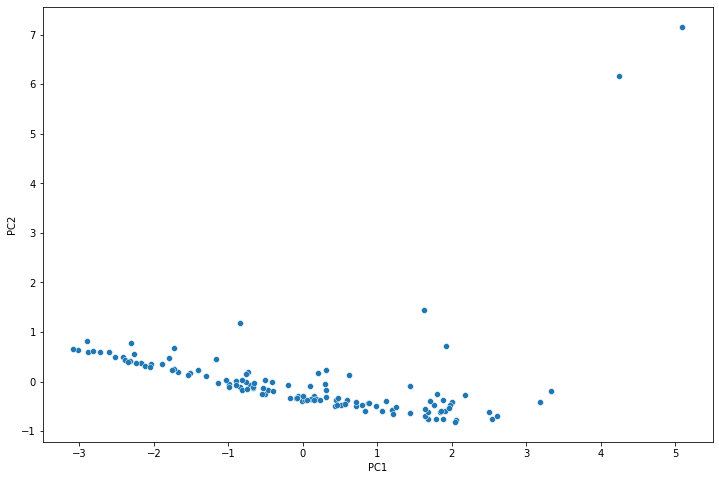

In [158]:
# Plot spread of data
fig = plt.figure(figsize = (12,8))
sb.scatterplot(x='PC1',y='PC2',data=pcs_df2)
plt.show()

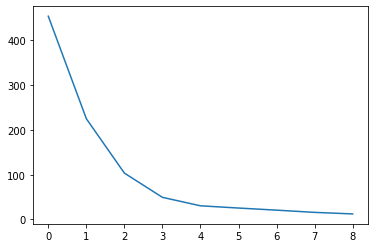

In [159]:
# Elbow plot for the most optimum number of K-Means clusters
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(pcs_df2)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)
plt.show()

In [160]:
# Fit K-Means clustering
model_clus2 = KMeans(n_clusters = 2, max_iter=50,random_state = 50)
model_clus2.fit(pcs_df2)

KMeans(max_iter=50, n_clusters=2, random_state=50)

In [161]:
# Cluster data accordingly
dat4=pcs_df2
dat4.index = pd.RangeIndex(len(dat4.index))
dat_km = pd.concat([dat4, pd.Series(model_clus2.labels_)], axis=1)
dat_km.columns = ['PC1','PC2','ClusterID']
dat_km

,PC1,PC2,ClusterID
0,-0.504470,0.041070,1
1,-3.019560,0.634132,1
2,-1.414386,0.234534,1
3,-1.675776,0.184459,1
4,2.173764,-0.271062,0
...,...,...,...
121,-2.318970,0.409282,1
122,1.642309,-0.550550,0
123,-0.416415,-0.017917,1
124,-2.597272,0.602423,1


In [162]:
dat_km['ClusterID'].value_counts()

0    70
1    56
Name: ClusterID, dtype: int64

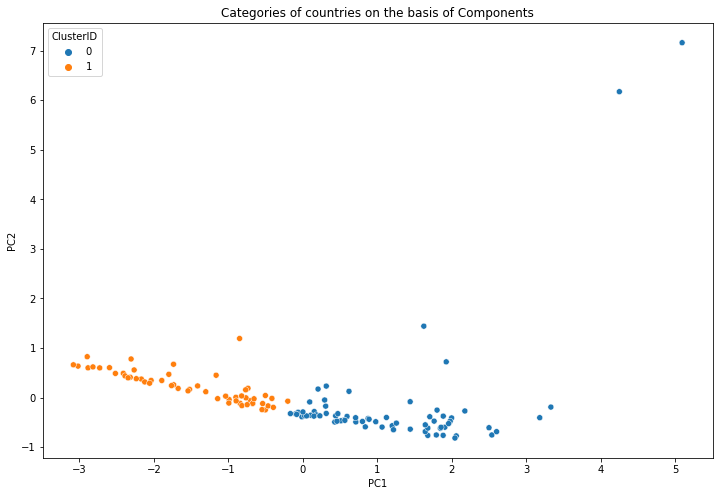

In [163]:
# Plot cluster of data
fig = plt.figure(figsize = (12,8))
sb.scatterplot(x='PC1',y='PC2',hue='ClusterID',legend='full',data=dat_km)

plt.title('Categories of countries on the basis of Components')
plt.show()

In [164]:
# Merge location with clustering data
dat5=pd.merge(cluster_data,dat_km, left_index=True,right_index=True)
dat5.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index,PC1,PC2,ClusterID
0,Vietnam,2021-10-23,308.127,6171.884,75.40,0.704,-0.504470,0.041070,1
1,Niger,2022-03-12,16.955,926.000,62.42,0.394,-3.019560,0.634132,1
2,Nepal,2022-03-12,204.430,2442.804,70.78,0.602,-1.414386,0.234534,1
3,Namibia,2022-03-12,3.078,9541.808,63.71,0.646,-1.675776,0.184459,1
4,Netherlands,2022-03-12,508.544,48472.545,82.28,0.944,2.173764,-0.271062,0


### Finding correlation for data
- Plot correlation matrix for all data
- Find the most relevant variables

In [144]:
corr = merged_data.corr()
with pd.option_context('display.precision', 2):
    style = corr.style.background_gradient(cmap='coolwarm').format(precision=2)
style

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
total_cases,1.00,0.61,0.65,0.92,0.57,0.61,0.27,0.11,0.13,0.27,0.07,0.09,-0.02,0.73,0.14,0.73,0.05,0.42,0.02,0.75,0.17,0.93,0.76,0.11,0.04,0.76,0.05,0.02,-0.03,0.75,0.72,0.72,0.78,0.56,0.62,0.15,0.17,0.12,0.11,0.06,0.52,0.01,0.04,0.50,-0.03,0.09,0.09,0.09,0.08,-0.07,-0.10,0.05,0.08,-0.07,0.05,-0.02,0.09,0.11,0.82,0.12,0.02,0.21,0.00,0.05,0.00,0.03,0.00,0.03
new_cases,0.61,1.00,0.94,0.52,0.59,0.57,0.23,0.35,0.31,0.17,0.12,0.12,0.05,0.63,0.17,0.72,0.12,0.41,0.13,0.72,0.32,0.56,0.65,0.11,0.10,0.64,0.11,0.15,-0.04,0.35,0.31,0.34,0.64,0.25,0.28,0.16,0.13,0.12,0.22,0.04,0.24,-0.02,0.06,0.31,-0.02,0.10,0.11,0.11,0.09,-0.07,-0.10,0.02,0.09,-0.03,0.05,0.03,0.10,0.12,0.47,0.07,0.07,0.11,-0.05,-0.01,0.05,-0.04,-0.04,-0.04
new_cases_smoothed,0.65,0.94,1.00,0.56,0.60,0.63,0.24,0.29,0.33,0.18,0.12,0.13,0.03,0.68,0.19,0.78,0.14,0.46,0.14,0.79,0.35,0.59,0.67,0.11,0.09,0.68,0.11,0.16,-0.04,0.38,0.33,0.36,0.70,0.25,0.30,0.16,0.13,0.12,0.24,0.04,0.25,-0.02,0.06,0.33,-0.02,0.11,0.12,0.11,0.09,-0.07,-0.10,0.02,0.09,-0.03,0.05,0.03,0.10,0.12,0.52,0.05,0.05,0.11,-0.06,-0.01,0.06,-0.04,-0.04,-0.04
total_deaths,0.92,0.52,0.56,1.00,0.60,0.65,0.22,0.06,0.06,0.38,0.11,0.13,-0.01,0.78,0.16,0.76,0.05,0.48,-0.00,0.77,0.14,0.82,0.71,0.05,0.01,0.66,0.00,0.04,-0.04,0.66,0.64,0.65,0.66,0.52,0.58,0.10,0.14,0.07,0.00,0.08,0.49,0.04,0.05,0.46,-0.05,0.09,0.08,0.08,0.06,-0.10,-0.13,0.05,0.06,-0.08,0.11,-0.04,0.10,0.11,0.95,0.32,0.10,0.36,-0.01,0.04,0.01,0.02,-0.01,0.05
new_deaths,0.57,0.59,0.60,0.60,1.00,0.94,0.09,0.07,0.07,0.17,0.31,0.30,-0.02,0.86,0.30,0.86,0.19,0.70,0.35,0.84,0.31,0.45,0.59,-0.02,-0.01,0.56,-0.01,0.14,-0.05,0.28,0.27,0.25,0.54,0.32,0.34,-0.08,-0.07,-0.11,0.01,0.01,0.35,0.04,0.14,0.42,-0.04,0.08,0.07,0.07,0.05,-0.08,-0.10,0.04,0.05,-0.05,0.09,-0.03,0.08,0.10,0.46,0.29,0.40,0.16,-0.14,-0.07,0.13,-0.10,-0.11,-0.09
new_deaths_smoothed,0.61,0.57,0.63,0.65,0.94,1.00,0.09,0.06,0.07,0.19,0.26,0.32,-0.03,0.92,0.33,0.92,0.20,0.78,0.38,0.90,0.33,0.48,0.59,-0.02,-0.01,0.59,-0.01,0.14,-0.05,0.30,0.29,0.27,0.61,0.32,0.36,-0.08,-0.08,-0.11,0.01,0.02,0.37,0.05,0.15,0.44,-0.04,0.08,0.08,0.07,0.05,-0.09,-0.10,0.05,0.06,-0.05,0.09,-0.03,0.08,0.10,0.66,0.24,0.32,0.17,-0.15,-0.07,0.14,-0.11,-0.12,-0.09
total_cases_per_million,0.27,0.23,0.24,0.22,0.09,0.09,1.00,0.57,0.66,0.70,0.28,0.34,-0.03,0.08,0.21,0.11,0.26,-0.02,0.04,0.12,0.28,0.24,0.18,0.61,0.36,0.19,0.41,0.27,-0.07,0.03,-0.01,0.02,0.25,-0.08,-0.04,0.55,0.48,0.49,0.59,0.10,-0.07,-0.08,-0.13,-0.07,-0.03,0.35,0.33,0.32,0.27,-0.30,-0.13,0.03,0.35,0.07,0.34,0.20,0.32,0.37,0.17,0.19,0.05,0.51,0.10,0.

The TOP 10 most relevant data are
['weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million', 'icu_patients_per_million', 'hosp_patients', 'total_cases', 'new_vaccinations_smoothed', 'people_fully_vaccinated', 'new_tests', 'aged_70_older', 'total_cases_per_million']

## Find fully vaccinated rate and compare among clusters
- Split countries into clusters
- Find number of people fully vaccinated and the country's population
- Display barplot for each cluster

In [536]:
# Split data according to clusters
cluster1 = dat5[dat5["ClusterID"]==0]
cluster1.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index,PC1,PC2,ClusterID
4,Netherlands,2022-03-12,508.544,48472.545,82.28,0.944,2.173764,-0.271062,0
5,New Zealand,2022-03-12,18.206,36085.843,82.29,0.931,1.676248,-0.764135,0
8,Antigua and Barbuda,2022-03-12,231.845,21490.943,77.02,0.778,0.305033,-0.173354,0
9,North Macedonia,2022-03-12,82.600,13111.214,75.80,0.774,-0.065551,-0.296724,0
10,Thailand,2022-03-12,135.132,16277.671,77.15,0.777,0.151579,-0.282644,0


In [537]:
# Split data according to clusters
cluster2 = dat5[dat5["ClusterID"]==1]
cluster2.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index,PC1,PC2,ClusterID
0,Vietnam,2021-10-23,308.127,6171.884,75.40,0.704,-0.504470,0.041070,1
1,Niger,2022-03-12,16.955,926.000,62.42,0.394,-3.019560,0.634132,1
2,Nepal,2022-03-12,204.430,2442.804,70.78,0.602,-1.414386,0.234534,1
3,Namibia,2022-03-12,3.078,9541.808,63.71,0.646,-1.675776,0.184459,1
6,Nicaragua,2022-03-12,51.667,5321.444,74.48,0.660,-0.843727,-0.116647,1


In [538]:
# Grab vaccination data
vac = pd.DataFrame(general_data_clean[["location", "people_fully_vaccinated"]])
vac = vac.dropna()
vac.head()

,location,people_fully_vaccinated
442,Afghanistan,55624.0
451,Afghanistan,77560.0
455,Afghanistan,96910.0
457,Afghanistan,111082.0
458,Afghanistan,113739.0


In [539]:
# Get the latest poeple fully vaccinated data
vac = vac.sort_values(by=['people_fully_vaccinated']).drop_duplicates(subset='location', keep='last')
vac.head()

,location,people_fully_vaccinated
122808,Pitcairn,47.0
153159,Tokelau,968.0
113150,Niue,1288.0
104519,Montserrat,1749.0
52827,Falkland Islands,1775.0


In [540]:
# Get latest population data
pop = pd.DataFrame(general_data[["location", "population"]])
pop = pop.dropna()
pop = pop.sort_values(by=['population']).drop_duplicates(subset='location', keep='last')
pop.head()

,location,population
122771,Pitcairn,47.0
163509,Vatican,812.0
153112,Tokelau,1368.0
113136,Niue,1614.0
52622,Falkland Islands,3528.0


In [541]:
# Merge people fully vaccinated and population
vac_pop = vac.merge(pop, left_on=["location"], right_on=["location"])
vac_pop.head()

,location,people_fully_vaccinated,population
0,Pitcairn,47.0,47.0
1,Tokelau,968.0,1368.0
2,Niue,1288.0,1614.0
3,Montserrat,1749.0,4981.0
4,Falkland Islands,1775.0,3528.0


In [542]:
# Calculate the percentage of people vaccinated in across all countries
vac_pop["vac_pop_percentage"] = (vac_pop["people_fully_vaccinated"] / vac_pop["population"]) * 100
vac_pop.head()

,location,people_fully_vaccinated,population,vac_pop_percentage
0,Pitcairn,47.0,47.0,100.000000
1,Tokelau,968.0,1368.0,70.760234
2,Niue,1288.0,1614.0,79.801735
3,Montserrat,1749.0,4981.0,35.113431
4,Falkland Islands,1775.0,3528.0,50.311791


In [543]:
# Merge data according to cluster
cluster1 = cluster1.merge(vac_pop, left_on=["location"], right_on=["location"])
cluster1.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index,PC1,PC2,ClusterID,people_fully_vaccinated,population,vac_pop_percentage
0,Netherlands,2022-03-12,508.544,48472.545,82.28,0.944,2.173764,-0.271062,0,12361264.0,17173094.0,71.980413
1,New Zealand,2022-03-12,18.206,36085.843,82.29,0.931,1.676248,-0.764135,0,3990111.0,5126300.0,77.836081
2,Antigua and Barbuda,2022-03-12,231.845,21490.943,77.02,0.778,0.305033,-0.173354,0,61550.0,98728.0,62.343003
3,North Macedonia,2022-03-12,82.600,13111.214,75.80,0.774,-0.065551,-0.296724,0,834203.0,2082661.0,40.054670
4,Thailand,2022-03-12,135.132,16277.671,77.15,0.777,0.151579,-0.282644,0,49939445.0,69950844.0,71.392198


In [544]:
cluster1.describe()[["vac_pop_percentage"]]

,vac_pop_percentage
count,70.000000
mean,67.942954
std,15.706366
min,25.925866
25%,61.289240
50%,71.743893
75%,78.205564
max,95.723787


In [545]:
# Merge data according to cluster
cluster2 = cluster2.merge(vac_pop, left_on=["location"], right_on=["location"])
cluster2.head()

,location,date,population_density,gdp_per_capita,life_expectancy,human_development_index,PC1,PC2,ClusterID,people_fully_vaccinated,population,vac_pop_percentage
0,Vietnam,2021-10-23,308.127,6171.884,75.40,0.704,-0.504470,0.041070,1,77637834.0,98168829.0,79.086035
1,Niger,2022-03-12,16.955,926.000,62.42,0.394,-3.019560,0.634132,1,1541167.0,25130810.0,6.132580
2,Nepal,2022-03-12,204.430,2442.804,70.78,0.602,-1.414386,0.234534,1,18594712.0,29674920.0,62.661372
3,Namibia,2022-03-12,3.078,9541.808,63.71,0.646,-1.675776,0.184459,1,378399.0,2587344.0,14.624998
4,Nicaragua,2022-03-12,51.667,5321.444,74.48,0.660,-0.843727,-0.116647,1,4113547.0,6702379.0,61.374431


In [546]:
cluster2.describe()[["vac_pop_percentage"]]

,vac_pop_percentage
count,56.000000
mean,32.756255
std,23.348385
min,0.929397
25%,12.885144
50%,29.108288
75%,53.763873
max,81.928228


In [547]:
cluster_pop_avg = pd.DataFrame({'Cluster_ID':['Cluster 1', 'Cluster 2'], 'Vac_Rate':[cluster1["vac_pop_percentage"].mean(), cluster2["vac_pop_percentage"].mean()]})
cluster_pop_avg.head()

,Cluster_ID,Vac_Rate
0,Cluster 1,67.942954
1,Cluster 2,32.756255


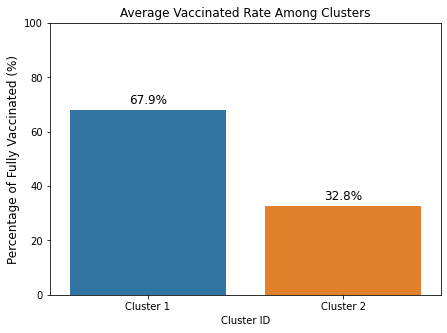

In [548]:
fig = plt.figure(figsize = (7,5))
s=sb.barplot(x='Cluster_ID',y='Vac_Rate',data=cluster_pop_avg)
plt.bar_label(s.containers[0], fmt='%.1f%%', padding=3, fontsize=12)
plt.xlabel('Cluster ID', fontsize=10)
plt.ylabel('Percentage of Fully Vaccinated (%)', fontsize=12)
plt.title('Average Vaccinated Rate Among Clusters')
plt.ylim(0, 100)
plt.show()

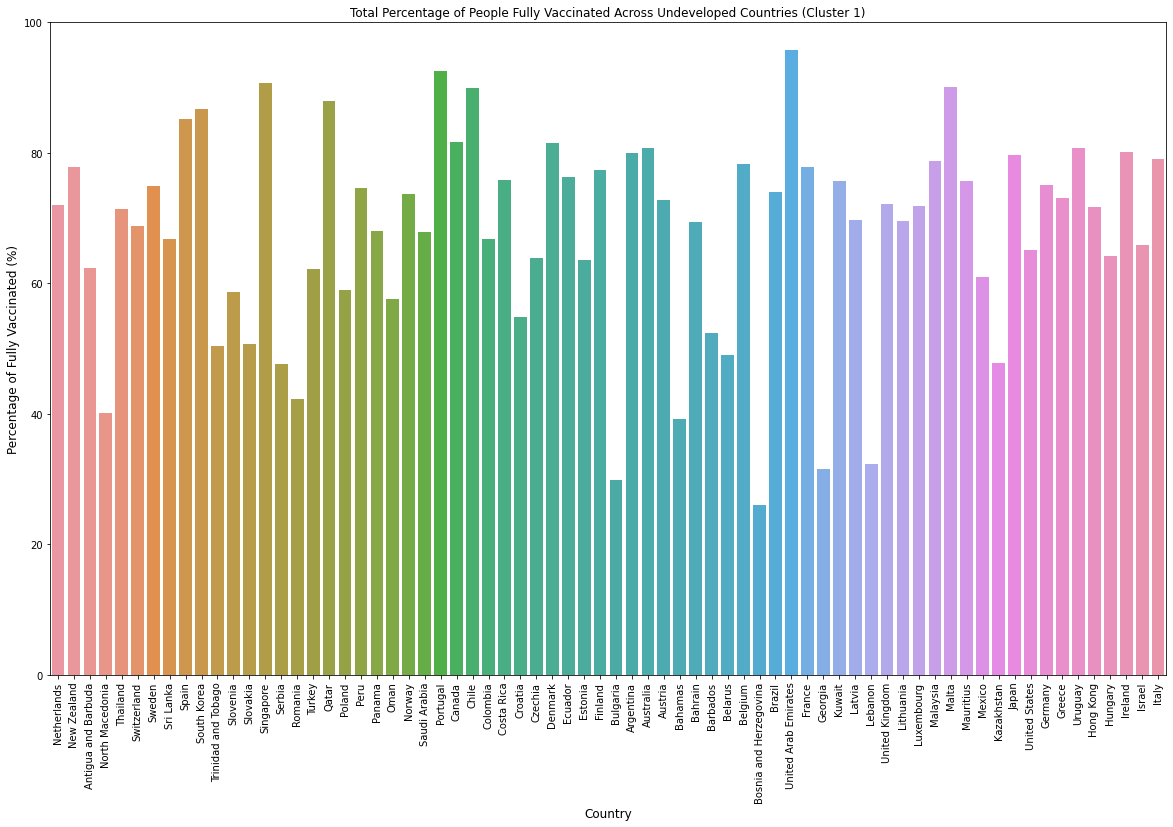

In [549]:
# Plot vaccination data for countries in cluster
fig = plt.figure(figsize = (20,12))
s=sb.barplot(x='location',y='vac_pop_percentage',data=cluster1)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Percentage of Fully Vaccinated (%)', fontsize=12)
plt.title('Total Percentage of People Fully Vaccinated Across Undeveloped Countries (Cluster 1)')
plt.ylim(0, 100)
plt.show()

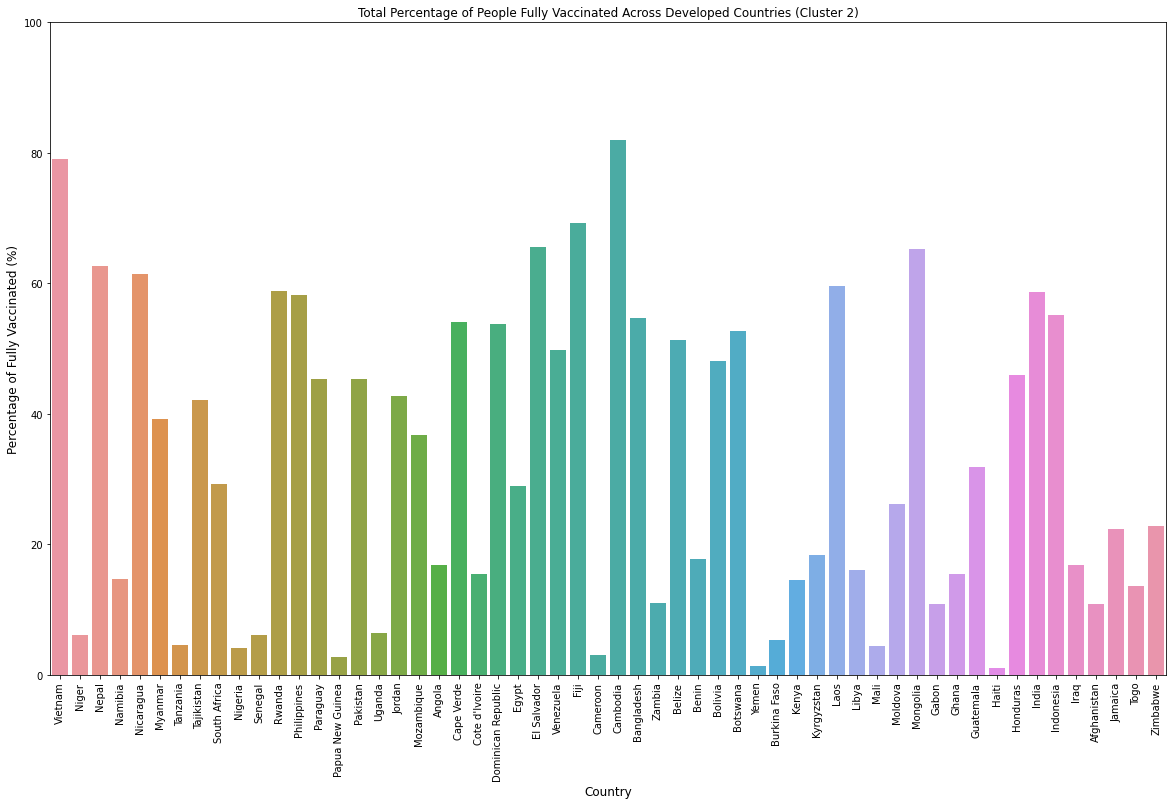

In [550]:
# Plot vaccination data for countries in cluster
fig = plt.figure(figsize = (20,12))
s=sb.barplot(x='location',y='vac_pop_percentage',data=cluster2)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Percentage of Fully Vaccinated (%)', fontsize=12)
plt.title('Total Percentage of People Fully Vaccinated Across Developed Countries (Cluster 2)')
plt.ylim(0, 100)
plt.show()

## Average mobility across each cluster

In [551]:
cluster1_data = merged_data.merge(cluster1[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster1_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,ATG,North America,Antigua and Barbuda,2020-03-13,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.429,8.286,0.500,-0.286,4.000,3.714
1,ATG,North America,Antigua and Barbuda,2020-03-14,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.286,7.714,1.167,-2.571,2.714,2.857
2,ATG,North America,Antigua and Barbuda,2020-03-15,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.429,7.143,1.167,-4.429,-0.571,1.714
3,ATG,North America,Antigua and Barbuda,2020-03-16,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-4.000,5.857,2.500,-5.429,-1.857,-0.714
4,ATG,North America,Antigua and Barbuda,2020-03-17,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-7.429,4.286,4.167,-8.000,-4.286,-3.429


In [552]:
cluster2_data = merged_data.merge(cluster2[['location']], how='inner', left_on=['location'], right_on=['location'])
cluster2_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.286,0.286,6.143,2.714,6.000
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.286,0.429,6.143,2.429,6.143
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.857,6.571,0.429,6.571,2.571,6.143
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000,6.143,0.571,6.429,2.857,6.286
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.714,5.571,0.857,6.000,2.429,6.143


In [553]:
retail_c1 = cluster1_data['retail_and_recreation'].mean()
grocery_c1 = cluster1_data['grocery_and_pharmacy'].mean()
residential_c1 = cluster1_data['residential'].mean()
transit_c1 = cluster1_data['transit_stations'].mean()
parks_c1 = cluster1_data['parks'].mean()
workplaces_c1 = cluster1_data['workplaces'].mean()

retail_c2 = cluster2_data['retail_and_recreation'].mean()
grocery_c2 = cluster2_data['grocery_and_pharmacy'].mean()
residential_c2 = cluster2_data['residential'].mean()
transit_c2 = cluster2_data['transit_stations'].mean()
parks_c2 = cluster2_data['parks'].mean()
workplaces_c2 = cluster2_data['workplaces'].mean()

cluster_a_mobility = pd.DataFrame({'Location':['Retail', 'Grocery', 'Residential', 'Transit', 'Parks', 'Workplaces',
                                              'Retail', 'Grocery', 'Residential', 'Transit', 'Parks', 'Workplaces'], 
                                'Average Mobility':[retail_c1, grocery_c1, residential_c1, transit_c1, parks_c1, workplaces_c1,
                                                   retail_c2, grocery_c2, residential_c2, transit_c2, parks_c2, workplaces_c2],
                                'Cluster':['1', '1', '1', '1', '1', '1',
                                          '2', '2', '2', '2', '2', '2']})
cluster_a_mobility.head(11)

,Location,Average Mobility,Cluster
0,Retail,-18.582049,1
1,Grocery,3.714593,1
2,Residential,7.067497,1
3,Transit,-24.705196,1
4,Parks,13.706085,1
5,Workplaces,-20.681746,1
6,Retail,-2.020971,2
7,Grocery,19.541519,2
8,Residential,6.299733,2
9,Transit,-8.149119,2


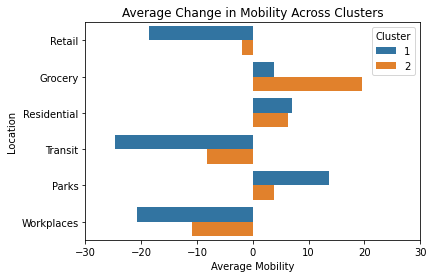

In [565]:
sb.barplot(x='Average Mobility', y='Location', hue='Cluster', data=cluster_a_mobility, orient='h')
plt.title('Average Change in Mobility Across Clusters')
plt.xlim(-30, 30)
plt.show()

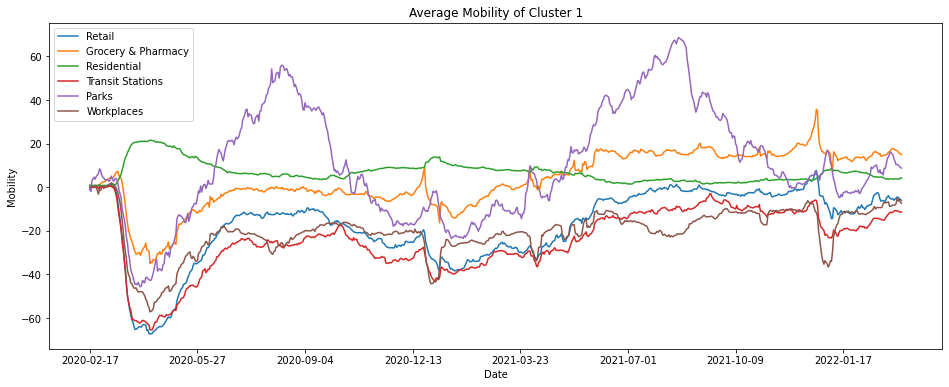

In [555]:
mobility_trend_c1 = pd.DataFrame(data = cluster1_data[["retail_and_recreation", "grocery_and_pharmacy", "residential", 
                                        "transit_stations", "parks", "workplaces"]].groupby(cluster1_data["date"]).median())
f = plt.figure(figsize=(16, 6))
mobility_trend_c1["retail_and_recreation"].plot(kind = "line", label="Retail");
mobility_trend_c1["grocery_and_pharmacy"].plot(kind = "line", label="Grocery & Pharmacy");
mobility_trend_c1["residential"].plot(kind = "line", label="Residential");
mobility_trend_c1["transit_stations"].plot(kind = "line", label="Transit Stations");
mobility_trend_c1["parks"].plot(kind = "line", label="Parks");
mobility_trend_c1["workplaces"].plot(kind = "line", label="Workplaces");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Mobility")
plt.title("Average Mobility of Cluster 1");

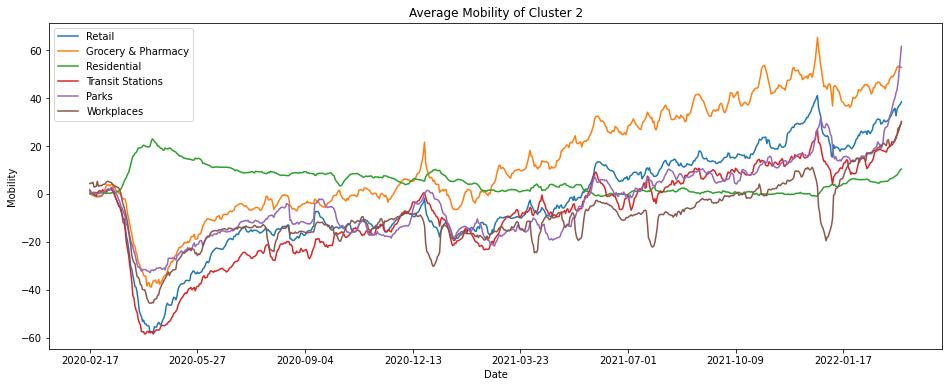

In [556]:
mobility_trend_c2 = pd.DataFrame(data = cluster2_data[["retail_and_recreation", "grocery_and_pharmacy", "residential", 
                                        "transit_stations", "parks", "workplaces"]].groupby(cluster2_data["date"]).median())
f = plt.figure(figsize=(16, 6))
mobility_trend_c2["retail_and_recreation"].plot(kind = "line", label="Retail");
mobility_trend_c2["grocery_and_pharmacy"].plot(kind = "line", label="Grocery & Pharmacy");
mobility_trend_c2["residential"].plot(kind = "line", label="Residential");
mobility_trend_c2["transit_stations"].plot(kind = "line", label="Transit Stations");
mobility_trend_c2["parks"].plot(kind = "line", label="Parks");
mobility_trend_c2["workplaces"].plot(kind = "line", label="Workplaces");
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Mobility")
plt.title("Average Mobility of Cluster 2");

We can observe that the average mobility influctuates over time with some drastic changes during some intervals during COVID-19. Mobility across each clusters are also trends differently (except residential).

## New COVID-19 Cases

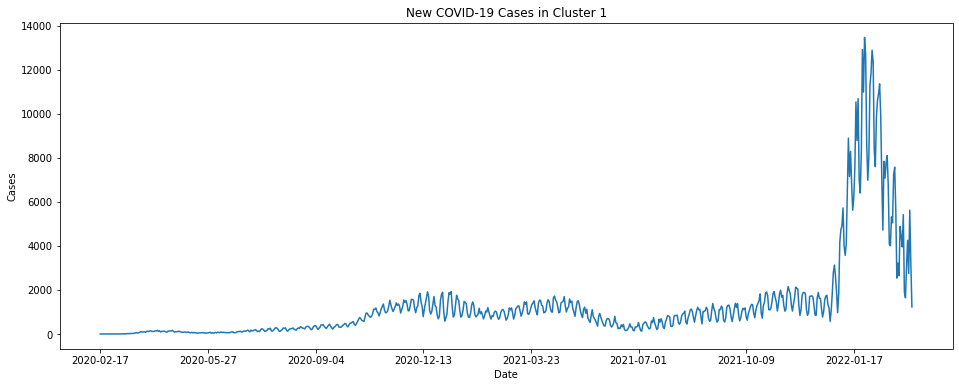

In [579]:
covid_cases1 = pd.DataFrame(data = cluster1_data[["new_cases", "total_deaths"]].groupby(cluster1_data["date"]).median())
f = plt.figure(figsize=(16, 6))
covid_cases1["new_cases"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("New COVID-19 Cases in Cluster 1");

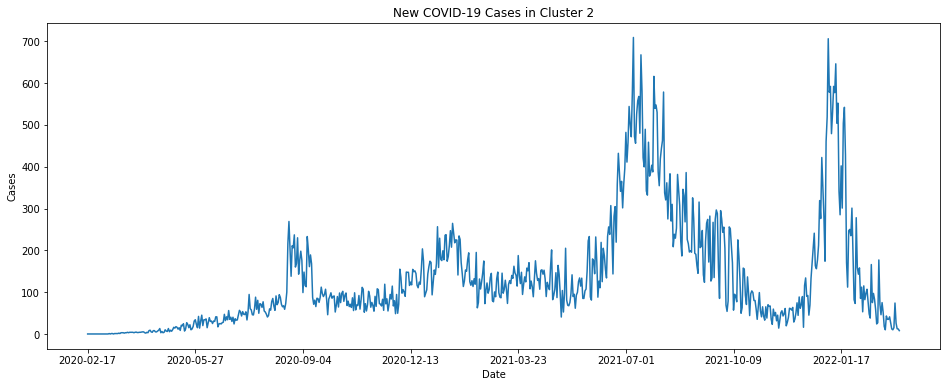

In [581]:
covid_cases2 = pd.DataFrame(data = cluster2_data[["new_cases", "total_deaths"]].groupby(cluster2_data["date"]).median())
f = plt.figure(figsize=(16, 6))
covid_cases2["new_cases"].plot(kind = "line");
plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("New COVID-19 Cases in Cluster 2");

We can observe the difference in new COVID-19 cases among each clusters with cluster 2 having more spikes and disparity whilst the new cases in cluster 1 are mostly stagnant.
- The highest peak of new COVID-19 cases for cluster 1 was in January 2022.
- The highest peak of new COVID-19 cases for cluster 2 is similiar to cluster 1 with addition of July 2021.

## Finding the best regression model for prediction
- Scale data using MinMaxScaler
- Run data in each cluster through 5 different regression models (Linear Regression, Support Vector Regression, Stochastic Gradient Descent, Decision Tree Regressor, MLP Regression)

In [595]:
relevant_columns = ['icu_patients_per_million', 'hosp_patients', 'total_cases', 'new_vaccinations_smoothed', 'people_fully_vaccinated', 'new_tests', 'aged_70_older', 'total_cases_per_million','retail_and_recreation', 'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks', 'workplaces']
cluster1_regression = cluster1_data[relevant_columns]
cluster1_regression.head()

,icu_patients_per_million,hosp_patients,total_cases,new_vaccinations_smoothed,people_fully_vaccinated,new_tests,aged_70_older,total_cases_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,NaN,NaN,1.0,NaN,NaN,NaN,4.631,10.129,1.429,8.286,0.500,-0.286,4.000,3.714
1,NaN,NaN,1.0,NaN,NaN,NaN,4.631,10.129,-0.286,7.714,1.167,-2.571,2.714,2.857
2,NaN,NaN,1.0,NaN,NaN,NaN,4.631,10.129,-2.429,7.143,1.167,-4.429,-0.571,1.714
3,NaN,NaN,1.0,NaN,NaN,NaN,4.631,10.129,-4.000,5.857,2.500,-5.429,-1.857,-0.714
4,NaN,NaN,1.0,NaN,NaN,NaN,4.631,10.129,-7.429,4.286,4.167,-8.000,-4.286,-3.429


In [596]:
cluster2_regression = cluster2_data[relevant_columns]
cluster2_regression.head()

,icu_patients_per_million,hosp_patients,total_cases,new_vaccinations_smoothed,people_fully_vaccinated,new_tests,aged_70_older,total_cases_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,NaN,NaN,5.0,NaN,NaN,NaN,1.337,0.126,1.000,6.286,0.286,6.143,2.714,6.000
1,NaN,NaN,5.0,NaN,NaN,NaN,1.337,0.126,0.857,6.286,0.429,6.143,2.429,6.143
2,NaN,NaN,5.0,NaN,NaN,NaN,1.337,0.126,0.857,6.571,0.429,6.571,2.571,6.143
3,NaN,NaN,5.0,NaN,NaN,NaN,1.337,0.126,1.000,6.143,0.571,6.429,2.857,6.286
4,NaN,NaN,5.0,NaN,NaN,NaN,1.337,0.126,0.714,5.571,0.857,6.000,2.429,6.143


In [597]:
scaler = MinMaxScaler()
cluster1_regression = cluster1_regression.fillna(0)
cluster1_regression = pd.DataFrame(scaler.fit_transform(cluster1_regression), columns = cluster1_regression.columns)
cluster1_regression.head()

,icu_patients_per_million,hosp_patients,total_cases,new_vaccinations_smoothed,people_fully_vaccinated,new_tests,aged_70_older,total_cases_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,0.0,0.0,1.257629e-08,0.0,0.0,0.0,0.250419,0.00002,0.601477,0.519188,0.275129,0.551246,0.140514,0.735505
1,0.0,0.0,1.257629e-08,0.0,0.0,0.0,0.250419,0.00002,0.590403,0.516053,0.286860,0.537469,0.138646,0.728260
2,0.0,0.0,1.257629e-08,0.0,0.0,0.0,0.250419,0.00002,0.576564,0.512923,0.286860,0.526267,0.133873,0.718597
3,0.0,0.0,1.257629e-08,0.0,0.0,0.0,0.250419,0.00002,0.566419,0.505874,0.310305,0.520237,0.132005,0.698071
4,0.0,0.0,1.257629e-08,0.0,0.0,0.0,0.250419,0.00002,0.544276,0.497262,0.339624,0.504736,0.128476,0.675118


<AxesSubplot:>

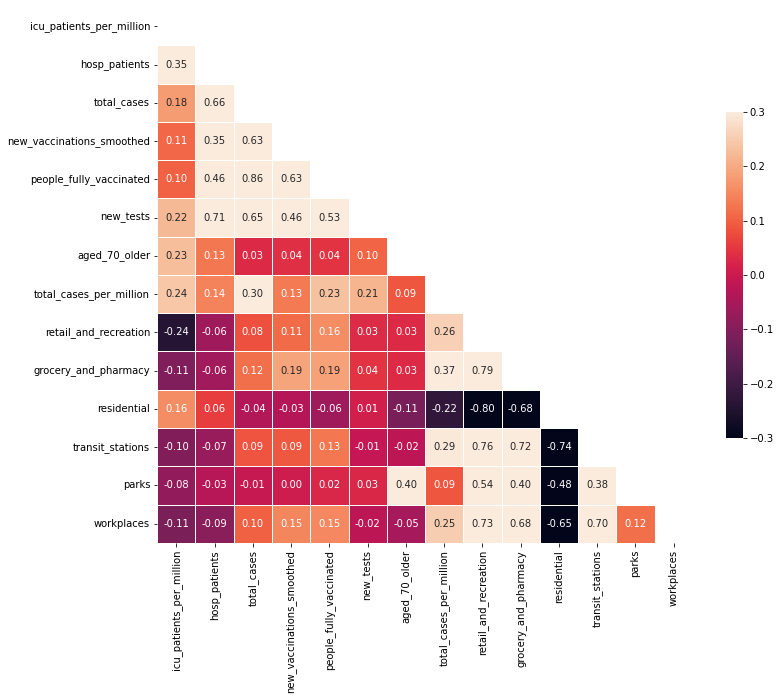

In [599]:
var_corr1 = cluster1_regression.corr()

mask = np.triu(np.ones_like(var_corr1, dtype=bool))

f, ax = plt.subplots(figsize=(12, 12))

sb.heatmap(var_corr1, mask=mask, cmap="rocket", vmin = -0.3, vmax = 0.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt = ".2f")

<AxesSubplot:>

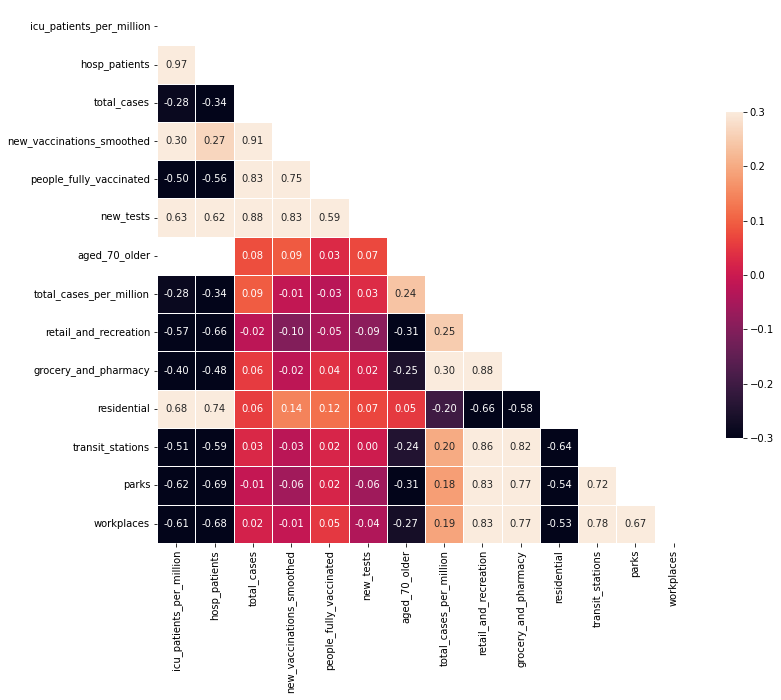

In [600]:
var_corr2 = cluster2_regression.corr()

mask = np.triu(np.ones_like(var_corr2, dtype=bool))

f, ax = plt.subplots(figsize=(12, 12))

sb.heatmap(var_corr2, mask=mask, cmap="rocket", vmin = -0.3, vmax = 0.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt = ".2f")

From the heatmap we can observe that each variable affect mobility with a slight difference in both clusters

In [601]:
y_columns = ['retail_and_recreation', 'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks', 'workplaces']
x_data = cluster1_regression.drop(y_columns, axis=1)
x_columns = x_data.columns.tolist()
print(x_columns)

['icu_patients_per_million', 'hosp_patients', 'total_cases', 'new_vaccinations_smoothed', 'people_fully_vaccinated', 'new_tests', 'aged_70_older', 'total_cases_per_million']


In [602]:
models = [LinearRegression(), svm.SVR(), SGDRegressor(), tree.DecisionTreeRegressor() , MLPRegressor(random_state=1, max_iter=500)]
x = cluster1_regression[x_columns]
for i in range(len(y_columns)):
#     print(y_columns[i])
    y = cluster1_regression[y_columns[i]]
    print(x.shape,y.shape)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
    for m in models:
        print()
        print(y_columns[i],m)
        model = m
        model.fit(x_train, y_train)

        y_prediction = model.predict(x_test)
        score=r2_score(y_test,y_prediction)
        print("r2 score is =", score)
        print("mean_sqrd_error is =",mean_squared_error(y_test,y_prediction))
        print("root_mean_squared error of is =",np.sqrt(mean_squared_error(y_test,y_prediction)))

(51960, 8) (51960,)

retail_and_recreation LinearRegression()
r2 score is = 0.1973596568473912
mean_sqrd_error is = 0.01655209500750111
root_mean_squared error of is = 0.12865494552290288

retail_and_recreation SVR()
r2 score is = 0.3675113448176839
mean_sqrd_error is = 0.01304321717822474
root_mean_squared error of is = 0.11420690512497368

retail_and_recreation SGDRegressor()
r2 score is = 0.18069074779499483
mean_sqrd_error is = 0.016895842202194762
root_mean_squared error of is = 0.12998400748628564

retail_and_recreation DecisionTreeRegressor()
r2 score is = 0.9646053946302717
mean_sqrd_error is = 0.0007299095738592345
root_mean_squared error of is = 0.02701683870957582

retail_and_recreation MLPRegressor(max_iter=500, random_state=1)
r2 score is = 0.371221360680707
mean_sqrd_error is = 0.012966709019161995
root_mean_squared error of is = 0.11387145831665631
(51960, 8) (51960,)

grocery_and_pharmacy LinearRegression()
r2 score is = 0.22674039600379603
mean_sqrd_error is = 0.009296

In [603]:
scaler = MinMaxScaler()
cluster2_regression = cluster2_regression.fillna(0)
cluster2_regression = pd.DataFrame(scaler.fit_transform(cluster2_regression), columns = cluster2_regression.columns)
cluster2_regression.head()

,icu_patients_per_million,hosp_patients,total_cases,new_vaccinations_smoothed,people_fully_vaccinated,new_tests,aged_70_older,total_cases_per_million,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,0.0,0.0,1.163034e-07,0.0,0.0,0.0,0.005135,4.586911e-07,0.339480,0.298363,0.355897,0.399173,0.248343,0.447032
1,0.0,0.0,1.163034e-07,0.0,0.0,0.0,0.005135,4.586911e-07,0.338938,0.298363,0.358083,0.399173,0.247565,0.447784
2,0.0,0.0,1.163034e-07,0.0,0.0,0.0,0.005135,4.586911e-07,0.338938,0.299246,0.358083,0.400945,0.247953,0.447784
3,0.0,0.0,1.163034e-07,0.0,0.0,0.0,0.005135,4.586911e-07,0.339480,0.297920,0.360253,0.400357,0.248733,0.448536
4,0.0,0.0,1.163034e-07,0.0,0.0,0.0,0.005135,4.586911e-07,0.338395,0.296148,0.364624,0.398581,0.247565,0.447784


In [604]:
y_columns = ['retail_and_recreation', 'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks', 'workplaces']
x_data = cluster2_regression.drop(y_columns, axis=1)
x_columns = x_data.columns.tolist()
print(x_columns)

['icu_patients_per_million', 'hosp_patients', 'total_cases', 'new_vaccinations_smoothed', 'people_fully_vaccinated', 'new_tests', 'aged_70_older', 'total_cases_per_million']


In [ ]:
models = [LinearRegression(), svm.SVR(), SGDRegressor(), tree.DecisionTreeRegressor() , MLPRegressor(random_state=1, max_iter=500)]
x = cluster2_regression[x_columns]
for i in range(len(y_columns)):
#     print(y_columns[i])
    y = cluster2_regression[y_columns[i]]
    print(x.shape,y.shape)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
    for m in models:
        print()
        print(y_columns[i],m)
        model = m
        model.fit(x_train, y_train)

        y_prediction = model.predict(x_test)
        score=r2_score(y_test,y_prediction)
        print("r2 score is =", score)
        print("mean_sqrd_error is =",mean_squared_error(y_test,y_prediction))
        print("root_mean_squared error of is =",np.sqrt(mean_squared_error(y_test,y_prediction)))

(40351, 8) (40351,)

retail_and_recreation LinearRegression()
r2 score is = 0.2095415259860638
mean_sqrd_error is = 0.012775292564540443
root_mean_squared error of is = 0.11302783977649242

retail_and_recreation SVR()
r2 score is = 0.397427628426114
mean_sqrd_error is = 0.009738700502601791
root_mean_squared error of is = 0.09868485447423932

retail_and_recreation SGDRegressor()
r2 score is = 0.17735063528860262
mean_sqrd_error is = 0.01329555777782217
root_mean_squared error of is = 0.1153063648625789

retail_and_recreation DecisionTreeRegressor()
r2 score is = 0.9801473210075273
mean_sqrd_error is = 0.0003208565543371899
root_mean_squared error of is = 0.017912469241765355

retail_and_recreation MLPRegressor(max_iter=500, random_state=1)
r2 score is = 0.3386113300903194
mean_sqrd_error is = 0.010689282276983304
root_mean_squared error of is = 0.10338898527881635
(40351, 8) (40351,)

grocery_and_pharmacy LinearRegression()
r2 score is = 0.20228666438979015
mean_sqrd_error is = 0.01316

#### Looking at the results of R2 score for all models, Decision Tree Regressor is the best.
- Best model for cluster 1: Decision Tree Regressor
- Best model for cluster 2: Decision Tree Regressor

## Conclusion
- As the average mobility for each country differs, clustering is needed to group similar country together. The optimal cluster for countries after performing EDA is 2. Developed country and Undeveloped country.
- Mobility among retail, transit station and workplaces has been affected the most during COVID-19. However, for countries in cluster 2, mobility in grocery place have increased drastically instead.
- Both clusters have different influctuation of COVID-19 cases. COVID-19 cases in cluster 1 are mostly stable while cluster 2 spikes frequently. The vaccination rate is also very different for both clusters.
- Mobility in both clusters are affected by different variable hence it crucial to cluster the countries first before performing regression if high accuracy is preferred!
- Prediction of mobility can be done using Decision Tree Regressor model and the accuracy is at least 90% for both clusters!
